# 6. Decision Trees and Ensemble Learning


This week, we'll talk about decision trees and tree-based ensemble algorithms

## 6.1 Credit risk scoring project

* Dataset: https://github.com/gastonstat/CreditScoring

In [1]:
# install xgboost library
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 2.1 MB/s eta 0:00:0000:0100:02m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 2.2 MB/s eta 0:00:0000:0100:03m


In [2]:
# Necessary import
import xgboost as xgb
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from IPython.display import display

## 6.2 Data cleaning and preparation

* Downloading the dataset
* Re-encoding the categorical variables
* Doing the train/validation/test split

In [3]:
# Link to data
data_url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [4]:
# Download the data
!wget $data_url

--2024-11-01 12:24:34--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178.21K   695KB/s    in 0.3s    

2024-11-01 12:24:35 (695 KB/s) - ‘CreditScoring.csv’ saved [182489/182489]



In [5]:
# Files first rows
!head CreditScoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In this dataset, some categorical variables were encoded as numerical ones.

In [6]:
# Read the data and store it as a dataframe
df = pd.read_csv("CreditScoring.csv")

In [7]:
# Lowercase columns names
df.columns = df.columns.str.lower()

In [8]:
# Target value counts
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [9]:
# Scheme for status encoding
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}
# Status encoding
df.status = df.status.map(status_values)

In [10]:
# Scheme for home encoding
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
# Home encoding
df.home = df.home.map(home_values)

# Scheme for marital encoding
marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
# Marital encoding
df.marital = df.marital.map(marital_values)

# Scheme for records encoding
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
# Records encoding
df.records = df.records.map(records_values)

# Scheme for job encoding
job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
# Job encoding
df.job = df.job.map(job_values)

In [11]:
# Data set first rows
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


Now, all the categorical variables values have been changed back to `string`.

In [12]:
# Data description
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


The columns of `income`, `assets` and `debt` have as maximum: `99999999`. This outlier is used in our dataset to indicate missing values.

In [13]:
# Change outliers to nan
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace = 99999999, value = np.nan)

Note that the function `replace` is similar to `map` but only uses one value.

In [14]:
# Data Description
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


No more missing values for `income`, `assets` and `debts`!

In [15]:
# Remove `unk` status from the dataframe
df = df[df.status != 'unk'].reset_index(drop = True)

We removed any record whose status is `unknown` as it is not relevant for our model.

In [16]:
# Split the train data into full_train and test
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 11)
# Split the full_train data into train and validation
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 11)

In [17]:
# Reset indexes
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [18]:
# Encode and extract target as numerical values
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [19]:
# Delete targets from train, test and validation dataframes
del df_train['status']
del df_val['status']
del df_test['status']

In [20]:
# Train data set 5 first rows
df_train.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897


## 6.3 Decision trees

* How a decision tree looks like
* Training a decision tree 
* Overfitting
* Controlling the size of a tree

In [21]:
# Decision tree function for risk scoring
def assess_risk(client):
    # Branch for Record
    if client['records'] == 'yes':
        # Branch  for part-time Job
        if client['job'] == 'parttime':
            # result
            return 'default'
        # Branch for no part-time Job
        else:
            # result
            return 'ok'
    # Branch for no Record
    else:
        # Branch for higher assets
        if client['assets'] > 6000:
            # result
            return 'ok'
        # Branch for lower assets
        else:
            # result
            return 'default'

In [22]:
# First record
x_0 = df_train.iloc[0].to_dict()

# display first record
display(x_0)

# Decision for first record
assess_risk(x_0)

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

'ok'

In [23]:
# Fill missing values and convert data as dictionaries
train_dicts = df_train.fillna(0).to_dict(orient = 'records')

# Initialize vectorizer
dv = DictVectorizer(sparse = False)
# One-Hot-encoding
X_train = dv.fit_transform(train_dicts)

# Initialize decision tree classifier
dt = DecisionTreeClassifier()
# Model training
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [24]:
# Fill missing values and convert data as dictionaries
val_dicts = df_val.fillna(0).to_dict(orient = 'records')
# One-Hot-encoding
X_val = dv.transform(val_dicts)

# Make soft predictions for training data
y_pred_train = dt.predict_proba(X_train)[:, 1]
# Make soft predictions for validation data
y_pred_val = dt.predict_proba(X_val)[:, 1]

# Training and Validation AUC scores
print(f"Train_AUC: {roc_auc_score(y_train, y_pred_train)}, Val_AUC: {roc_auc_score(y_val, y_pred_val)}")

Train_AUC: 1.0, Val_AUC: 0.6553274321280667


The training score is perfect but the model has difficulties to generalize. Indeed, its AUC score on the validation set is lower than the one for training.

This shows an **overfitting**: when a model learns too much about the training dataset, memorizing it in such a way to have difficulties performing on new unseen data, when this one is too different from the known dataset. Reducing the depth of the tree can help to remove too specific rules from the model, so it can generalize better:

In [25]:
# Initialize a decision Tree with a maximum depth of 3
dt = DecisionTreeClassifier(max_depth = 3)
# Model Training
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [26]:
# Make soft predictions for training data
y_pred_train = dt.predict_proba(X_train)[:, 1]
# Make soft predictions for validation data
y_pred_val = dt.predict_proba(X_val)[:, 1]

# Training and Validation AUC scores
print(f"Train_AUC: {roc_auc_score(y_train, y_pred_train)}, Val_AUC: {roc_auc_score(y_val, y_pred_val)}")

Train_AUC: 0.7761016984958594, Val_AUC: 0.7389079944782155


The training score has decreased considerably, and the validation one has increased. The difference between the two scores is not that big anymore, showing our model now generalizes better. 

In [27]:
# Visualize the decision tree model rules
print(export_text(dt, feature_names = list(dv.get_feature_names_out())))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0



## 6.4 Decision tree learning algorithm

* Finding the best split for one column
* Finding the best split for the entire dataset
* Stopping criteria
* Decision tree learning algorithm

In [28]:
# Assets and status data set
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default']
]

# Create dataframe
df_example = pd.DataFrame(data, columns = ['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [29]:
# Sort data by assets
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


Let's classify the data using only one threshold for a condition on `assets`:

In [30]:
# Threshold
T = 4000
# Left dataframe / child node
df_left = df_example[df_example.assets <= T]
# Right dataframe / child node
df_right = df_example[df_example.assets > T]

# Display left child node
display(df_left)
# Status distribution
print(df_left.status.value_counts(normalize = True))
# Display right child node
display(df_right)
# Status distribution
print(df_right.status.value_counts(normalize = True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64


To determine the best threshold, for the condition on a particular variable, the model can proceed to fine-tuning:

In [31]:
# Potential thresholds
Ts = [0, 2000, 3000, 4000, 5000, 8000]

# Fine tuning with all potential thresholds
for T in Ts:
    # Threshold
    print(f"Threshold: {T}")
    # Left dataframe / child node
    df_left = df_example[df_example.assets <= T]
    # Right dataframe / child node
    df_right = df_example[df_example.assets > T]

    # Display left child node
    display(df_left)
    # Status distribution
    print(df_left.status.value_counts(normalize = True))
    # Display right child node
    display(df_right)
    # Status distribution
    print(df_right.status.value_counts(normalize = True), end = "\n\n\n")

Threshold: 0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


Threshold: 2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


Threshold: 3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64


Threshold: 4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64


Threshold: 5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


Threshold: 8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64




The threshold leasing to the lower misclassification rate is the better one.

In [32]:
# Dataset with assets, debts and status
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

# Create dataframe
df_example = pd.DataFrame(data, columns = ['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [33]:
# Sort data by debt
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [34]:
# Dictionary of possible thresholds
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

# For each feature and its thresholds
for feature, Ts in thresholds.items():
    # Starting with a feature
    print('##########Start###########')
    # Feature
    print(f"Feature: {feature}")

    # Fine-Tune to get the best threshold
    for T in Ts:
        # Threshold
        print(f"Threshold: {T}")
        # Left dataframe / child node
        df_left = df_example[df_example.assets <= T]
        # Right dataframe / child node
        df_right = df_example[df_example.assets > T]
    
        # Display left child node
        display(df_left)
        # Status distribution
        print(df_left.status.value_counts(normalize = True))
        # Display right child node
        display(df_right)
        # Status distribution
        print(df_right.status.value_counts(normalize = True), end = "\n\n")
        
    # Finishing with a feature
    print('##########End###########', end = "\n\n\n")

##########Start###########
Feature: assets
Threshold: 0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

Threshold: 2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

Threshold: 3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

Threshold: 4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

Threshold: 5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

Threshold: 8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

##########End###########


##########Start###########
Feature: debt
Threshold: 500


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

Threshold: 1000


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

Threshold: 2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

##########End###########




## 6.5 Decision trees parameter tuning

* selecting `max_depth`
* selecting `min_samples_leaf`


In [35]:
# List of potential maximum depths
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

# Decision Tree model fine-tuning with maximum depth
for depth in depths: 
    # Initialize the model with a max_depth
    dt = DecisionTreeClassifier(max_depth = depth)
    # Model Training
    dt.fit(X_train, y_train)

    # Make soft predictions
    y_pred = dt.predict_proba(X_val)[:, 1]
    # AUC score
    auc = roc_auc_score(y_val, y_pred)
    
    print('Maximum depth: %4s -> AUC score: %.3f' % (depth, auc))

Maximum depth:    1 -> AUC score: 0.606
Maximum depth:    2 -> AUC score: 0.669
Maximum depth:    3 -> AUC score: 0.739
Maximum depth:    4 -> AUC score: 0.761
Maximum depth:    5 -> AUC score: 0.766
Maximum depth:    6 -> AUC score: 0.754
Maximum depth:   10 -> AUC score: 0.684
Maximum depth:   15 -> AUC score: 0.654
Maximum depth:   20 -> AUC score: 0.670
Maximum depth: None -> AUC score: 0.658


According to this model fine-tuning, the best parameter for the tree's maximum depth is between 4 and 6. We can now proceed to another fine-tuning considering those values.

In [36]:
# Initialize scores
scores = []

# Decision Tree fine-tuning with maximum-depth
for depth in [4, 5, 6]:
    # Decision Tree model fine-tuning with minimum samples per leaf
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        # Initialize the model with a max_depth and min_samples_leaf
        dt = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = s)
        # Model training
        dt.fit(X_train, y_train)

        # Make soft predictions
        y_pred = dt.predict_proba(X_val)[:, 1]
        # AUC score
        auc = roc_auc_score(y_val, y_pred)

        # Store parameters and score
        scores.append((depth, s, auc))

# Columns names
columns = ['max_depth', 'min_samples_leaf', 'auc']
# Create dataframe
df_scores = pd.DataFrame(scores, columns = columns)

# Visualize parameters with higher scores
df_scores.sort_values(by = "auc", ascending = False).head()

,max_depth,min_samples_leaf,auc
19,6,15,0.785250
18,6,10,0.778299
22,6,100,0.776434
20,6,20,0.774279
12,5,20,0.773537


In [37]:
# Pivot table
df_scores_pivot = df_scores.pivot(index = 'min_samples_leaf', columns = ['max_depth'], values = ['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.767  0.758
5                 0.761  0.768  0.762
10                0.761  0.762  0.778
15                0.764  0.773  0.785
20                0.761  0.774  0.774
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

When we have three variables, **pivot()** helps to turn one into rows, another in columns and a last one in values.

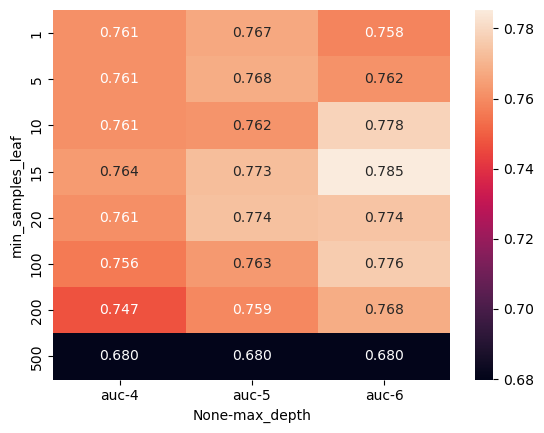

In [38]:
# Scores Heatmap
sns.heatmap(df_scores_pivot, annot = True, fmt = ".3f")
plt.show()

**Heatmaps** are useful to visualize lower and higher numerical values faster, and in this particular case, they help to identify the best parameters: `6` for the `max_depth` and `15` for the `min_samples_leaf`.

In [39]:
# Initialize an optimized model
dt = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 15)
# Model training
dt.fit(X_train, y_train)

# Decision rules
print(export_text(dt, feature_names = list(dv.get_feature_names_out())))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- assets <= 4250.00
|   |   |   |   |--- income <= 20.00
|   |   |   |   |   |--- seniority <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- seniority >  1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- income >  20.00
|   |   |   |   |   |--- expenses <= 71.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- expenses >  71.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  4250.00
|   |   |   |   |--- debt <= 1600.00
|   |   |   |   |   |--- seniority <= 2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- seniority >  2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- debt >  1600.00
|   |   |   |   |   |--- class: 1
|   |   |--- income >  74.50
|   |   |   |--- seniority <= 5.50
|   |   |   |   |--- amount <= 1330.00
|   |   |   |   |   |--- assets <= 3326.00
|   |   |   |   |   |   |--- clas

## 6.6 Ensembles and random forest

* Board of experts
* Ensembling models 
* Random forest - ensembling decision trees
* Tuning random forest


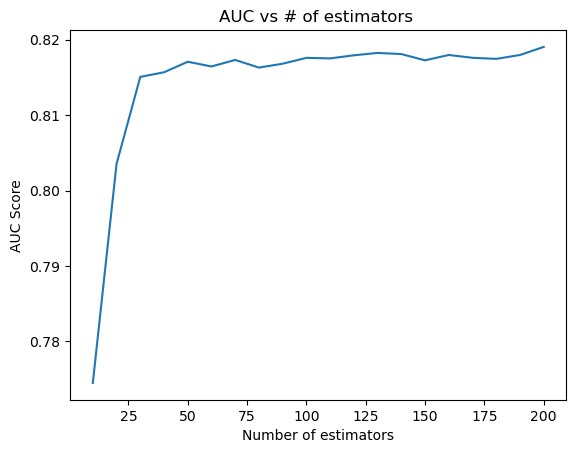

In [40]:
# Initialize scores
scores = []

# Random forest fine-tuning with number of trees
for n in range(10, 201, 10):
    # Initialize random forest classifier
    rf = RandomForestClassifier(n_estimators = n, random_state = 1)
    # Model training
    rf.fit(X_train, y_train)

    # Make soft predictions
    y_pred = rf.predict_proba(X_val)[:, 1]
    # AUC score
    auc = roc_auc_score(y_val, y_pred)

    # Store number of trees and corresponding score
    scores.append((n, auc))

# Create a dataframe for scores
df_scores = pd.DataFrame(scores, columns = ['n_estimators', 'auc'])

# Plot scores by estimators
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.xlabel("Number of estimators")
plt.ylabel("AUC Score")
plt.title("AUC vs # of estimators ")
plt.show()

In [41]:
# Initialize scores
scores = []

# Random forest fine-tuning with maximum depth
for d in [5, 10, 15]:
    # Random forest fine-tuning with number of trees
    for n in range(10, 201, 10):
        # Initialize random forest classifier
        rf = RandomForestClassifier(n_estimators = n,
                                    max_depth = d,
                                    random_state = 1)
        # Model training
        rf.fit(X_train, y_train)

        # Make soft predictions
        y_pred = rf.predict_proba(X_val)[:, 1]
        # AUC score
        auc = roc_auc_score(y_val, y_pred)

        # Store hyperparameters and corresponding score
        scores.append((d, n, auc))

# Columns names
columns = ['max_depth', 'n_estimators', 'auc']
# Create a dataframe for scores
df_scores = pd.DataFrame(scores, columns = columns)
df_scores.sort_values(by = "auc", ascending = False).head()

,max_depth,n_estimators,auc
35,10,160,0.825243
39,10,200,0.824923
37,10,180,0.824801
36,10,170,0.824632
38,10,190,0.824535


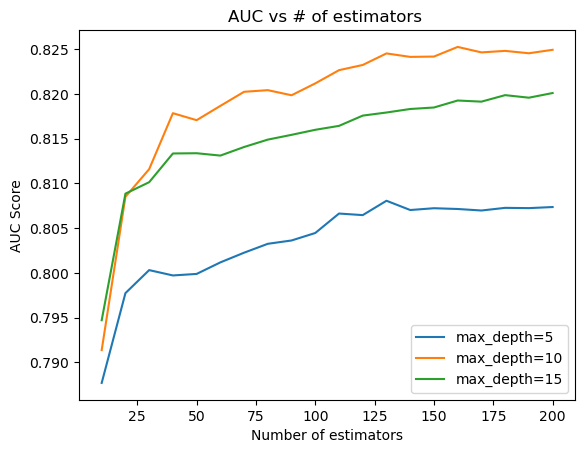

In [42]:
# For all selected depths
for d in [5, 10, 15]:
    # Get scores
    df_subset = df_scores[df_scores.max_depth == d]

    # Plot scores by estimators
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label = 'max_depth=%d' % d)

    # Labels and title
    plt.xlabel("Number of estimators")
    plt.ylabel("AUC Score")
    plt.title("AUC vs # of estimators ")
    plt.legend()

# To visualize the plot neatly
plt.show()

The maximum of depth of `10` leads to better results.

In [44]:
# Set the maximum depth
max_depth = 10

In [45]:
# Initialize scores
scores = []

# Values for min_samples_leaf
values = [1, 3, 5, 10, 50]

# Fine-tunining with minimum samples per leaf
for s in values:
    # Fine-tuning with number of estimators
    for n in range(10, 201, 10):
        # Initialize model
        rf = RandomForestClassifier(n_estimators = n,
                                    max_depth = max_depth,
                                    min_samples_leaf = s,
                                    random_state = 1)
        # Model training
        rf.fit(X_train, y_train)

        # Make soft predictions
        y_pred = rf.predict_proba(X_val)[:, 1]
        # Get AUC
        auc = roc_auc_score(y_val, y_pred)

        # Store hyperparameters and score
        scores.append((s, n, auc))

# Column names
columns = ['min_samples_leaf', 'n_estimators', 'auc']
# Create dataframe for scores
df_scores = pd.DataFrame(scores, columns = columns)
df_scores.sort_values(by = "auc", ascending = False).head()

,min_samples_leaf,n_estimators,auc
58,5,190,0.825952
35,3,160,0.825655
59,5,200,0.825383
52,5,130,0.825286
37,3,180,0.825268


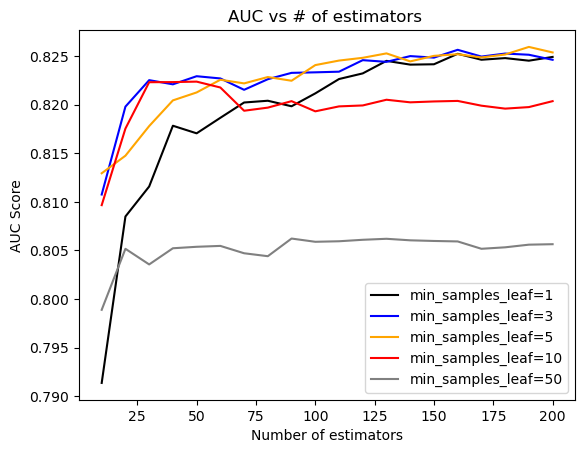

In [46]:
# Colors sets
colors = ['black', 'blue', 'orange', 'red', 'grey']

# For defined minimum samples per leaf
for s, col in zip(values, colors):
    # Get scores
    df_subset = df_scores[df_scores.min_samples_leaf == s]

    # Plot scores by estimators
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color = col,
             label = 'min_samples_leaf=%d' % s)
    # Labels and title
    plt.xlabel("Number of estimators")
    plt.ylabel("AUC Score")
    plt.title("AUC vs # of estimators ")
    plt.legend()

# For better visualization
plt.show()

In [47]:
# Set minimum sample leaf
min_samples_leaf = 3

# Initialize optimal model
rf = RandomForestClassifier(n_estimators = 200,
                            max_depth = max_depth,
                            min_samples_leaf = min_samples_leaf,
                            random_state = 1)
# Model training
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

Other useful parametes:

* `max_features`: the number of features to consider when looking for the best split.
* `bootstrap`: whether bootstrap samples (randomization on the row levels) are used when building trees. If false, the whole dataset is used to build each tree.
* `n_jobs`: the number of jobs to run in parallel. In other words, how many trees to train in parallel. Setting `n_jobs` to `-1` instructs the model to utilize all
available processor cores for parallel training, potentially speeding up the process.
   
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## 6.7 Gradient boosting and XGBoost

* Gradient boosting vs random forest
* Installing XGBoost
* Training the first model
* Performance monitoring
* Parsing xgboost's monitoring output


In [48]:
# Feature variables
features = list(dv.get_feature_names_out())
# Wrap the training data into an optimized structure
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
# Wrap the validation data into an optimized structure
dval = xgb.DMatrix(X_val, label = y_val, feature_names = features)

# XGBoost Model hyperparameters 
xgb_params = {
    'eta': 0.3, # learning rate
    'max_depth': 6, # maximum depth for trees
    'min_child_weight': 1, # minimum number of samples per child nodes
    'objective': 'binary:logistic', # binary classification
    'nthread': 8, # for parallelized training
    'seed': 1, # for reproducibility
    'verbosity': 1 # to show warnings if any during model traning
}

# Train model and store it
model = xgb.train(xgb_params, dtrain, num_boost_round = 10)

In [49]:
# Make soft predictions
y_pred = model.predict(dval)

# AUC score
roc_auc_score(y_val, y_pred)

0.8065256351262986

The model is quite good even using default parameters.

In [50]:
# Dataset on which we want to iterate our model
watchlist = [(dtrain, 'train'), (dval, 'val')]

To capture the output, we can use `%%capture output`.

In [51]:
%%capture output

# Model parameters
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc', # specify the evaluation metric
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Model training
model = xgb.train(xgb_params,
                  dtrain,
                  num_boost_round = 200,
                  verbose_eval = 5, # to print the evaluation after each 5 steps
                  evals = watchlist) # used for sequential evalutaion

In [52]:
# Get the output
s = output.stdout

# Output for the first 200 iterations
print(s[ : 200])

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	tr


In [53]:
# Function to traceback model training (iteration and scores)
def parse_xgb_output(output):
    # Initialize results
    results = []
    
    # Split output iterations
    for line in output.stdout.strip().split('\n'):
        # Split info for each iteration
        it_line, train_line, val_line = line.split('\t')
        # Get iteration number
        it = int(it_line.strip('[]'))
        # Get training score
        train = float(train_line.split(':')[1])
        # Get validation score
        val = float(val_line.split(':')[1])

        # Store iteration number and corresponding scores
        results.append((it, train, val))

    # Columns names
    columns = ['num_iter', 'train_auc', 'val_auc']
    # Create a dataframe
    df_results = pd.DataFrame(results, columns = columns)
    # return the result
    return df_results

In [54]:
# Traceback model training output
df_score = parse_xgb_output(output)
df_score.sort_values(by = "val_auc", ascending = False).head()

,num_iter,train_auc,val_auc
4,20,0.97464,0.81729
5,25,0.97953,0.81686
6,30,0.98579,0.81543
3,15,0.96554,0.81334
7,35,0.99011,0.81206


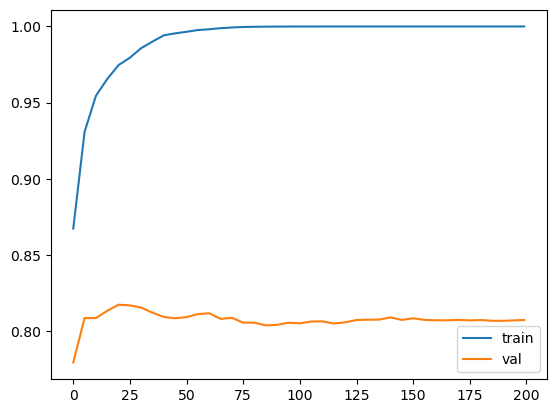

In [55]:
# Plot training information
plt.plot(df_score.num_iter, df_score.train_auc, label = 'train')
# Plot validation information
plt.plot(df_score.num_iter, df_score.val_auc, label = 'val')
# Legend
plt.legend()
# Visualize the plot
plt.show()

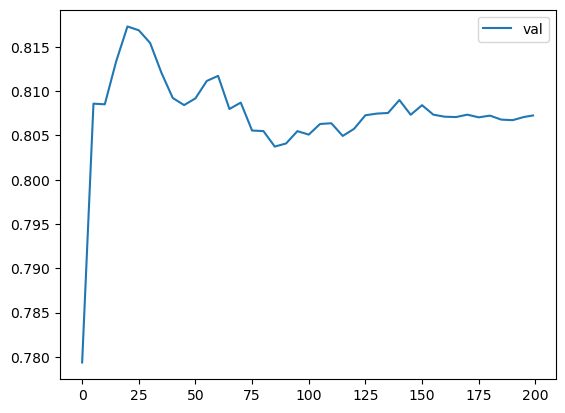

In [56]:
# Plot validation information
plt.plot(df_score.num_iter, df_score.val_auc, label = 'val')
# Legend
plt.legend()
# Visualize the plot
plt.show()

## 6.8 XGBoost parameter tuning

Tuning the following parameters:

* `eta`: learning rate / size of step which says how much weight models have when correcting the results of previous models.
* `max_depth`: maximum depth of a tree.
* `min_child_weight`: Minimum sample size of a child node.

In [57]:
# Initialize scores
scores = {}

In [58]:
%%capture output

# Model's parameters
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Model training
model = xgb.train(xgb_params, dtrain, 
                  num_boost_round = 200,
                  verbose_eval = 5,
                  evals = watchlist)

In [59]:
# Let's make `eta` parameter value a scores key
key = 'eta=%s' % (xgb_params['eta'])

# Check the key
print(key)

eta=0.01


In [60]:
# Value score for corresponsing eta parameter
scores[key] = parse_xgb_output(output)

# Visualize result for a particular `eta`
scores[key].sort_values(by = "val_auc", ascending = False).head()

,num_iter,train_auc,val_auc
40,199,0.93862,0.81575
39,195,0.93777,0.81554
38,190,0.93685,0.81481
37,185,0.93585,0.81429
36,180,0.93466,0.81340


In [61]:
%%capture output

# Model's parameters
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Model training
model = xgb.train(xgb_params, dtrain,
                  num_boost_round = 200,
                  verbose_eval = 5,
                  evals = watchlist)

In [62]:
# Let's make `eta` parameter value a scores key
key = 'eta=%s' % (xgb_params['eta'])

# Check the key
print(key)

eta=0.1


In [63]:
# Value score for corresponsing eta parameter
scores[key] = parse_xgb_output(output)

# Visualize result for a particular `eta`
scores[key].sort_values(by = "val_auc", ascending = False).head()

,num_iter,train_auc,val_auc
12,60,0.97708,0.82781
13,65,0.97937,0.82775
15,75,0.98315,0.82728
14,70,0.98214,0.82681
11,55,0.97475,0.82648


In [64]:
%%capture output

# Model's parameters
xgb_params = {
    'eta': 1, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Model training
model = xgb.train(xgb_params, dtrain,
                  num_boost_round = 200,
                  verbose_eval = 5,
                  evals = watchlist)

In [65]:
# Let's make `eta` parameter value a scores key
key = 'eta=%s' % (xgb_params['eta'])

# Check the key
print(key)

eta=1


In [66]:
# Value score for corresponsing eta parameter
scores[key] = parse_xgb_output(output)

# Visualize result for a particular `eta`
scores[key].sort_values(by = "val_auc", ascending = False).head()

,num_iter,train_auc,val_auc
39,195,1.0,0.79201
40,199,1.0,0.79199
36,180,1.0,0.79199
37,185,1.0,0.79179
38,190,1.0,0.79165


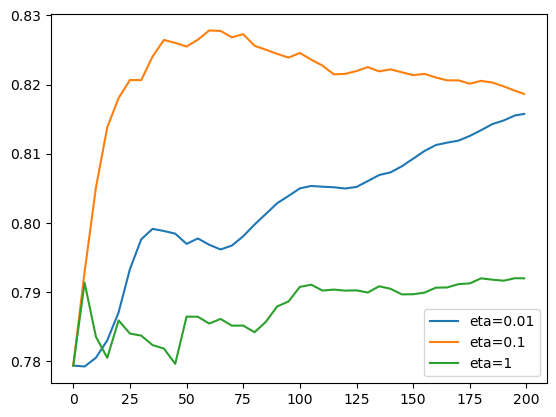

In [67]:
# For each learning parameter and its corresponding scores
for eta, df_score in scores.items():
    # Plot score vs iteration number
    plt.plot(df_score.num_iter, df_score.val_auc, label = eta)
    
# Legend
plt.legend()
# Visualize
plt.show()

The best learning parameter seems to be `0.1`.

In [68]:
# Initialize score
scores = {}

In [69]:
%%capture output

# Model's parameters
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Model training
model = xgb.train(xgb_params, dtrain,
                  num_boost_round = 200,
                  verbose_eval = 5,
                  evals = watchlist)

In [70]:
# Let's make `max_depth` parameter value a scores key
key = 'max_depth=%s' % (xgb_params['max_depth'])

# Check the key
print(key)

max_depth=3


In [71]:
# Value score for corresponsing `max_depth` parameter
scores[key] = parse_xgb_output(output)

# Visualize result for a particular `max_depth`
scores[key].sort_values(by = "val_auc", ascending = False).head()

,num_iter,train_auc,val_auc
22,110,0.92297,0.83170
26,130,0.92789,0.83169
33,165,0.93553,0.83169
27,135,0.92926,0.83165
31,155,0.93274,0.83159


In [72]:
%%capture output

# Model's parameters
xgb_params = {
    'eta': 0.1, 
    'max_depth': 4,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Model training
model = xgb.train(xgb_params, dtrain,
                  num_boost_round = 200,
                  verbose_eval = 5,
                  evals = watchlist)

In [73]:
# Let's make `max_depth` parameter value a scores key
key = 'max_depth=%s' % (xgb_params['max_depth'])

# Check the key
print(key)

max_depth=4


In [74]:
# Value score for corresponsing `max_depth` parameter
scores[key] = parse_xgb_output(output)

# Visualize result for a particular `max_depth`
scores[key].sort_values(by = "val_auc", ascending = False).head()

,num_iter,train_auc,val_auc
18,90,0.94563,0.82952
19,95,0.94720,0.82933
20,100,0.94870,0.82897
17,85,0.94288,0.82897
23,115,0.95391,0.82876


In [75]:
%%capture output

# Model's parameters
xgb_params = {
    'eta': 0.1, 
    'max_depth': 7,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Model training
model = xgb.train(xgb_params, dtrain,
                  num_boost_round = 200,
                  verbose_eval = 5,
                  evals = watchlist)

In [76]:
# Let's make `max_depth` parameter value a scores key
key = 'max_depth=%s' % (xgb_params['max_depth'])

# Check the key
print(key)

max_depth=7


In [77]:
# Value score for corresponsing `max_depth` parameter
scores[key] = parse_xgb_output(output)

# Visualize result for a particular `max_depth`
scores[key].sort_values(by = "val_auc", ascending = False).head()

,num_iter,train_auc,val_auc
16,80,0.99571,0.82274
15,75,0.99490,0.82190
17,85,0.99659,0.82157
13,65,0.99243,0.82147
21,105,0.99857,0.82143


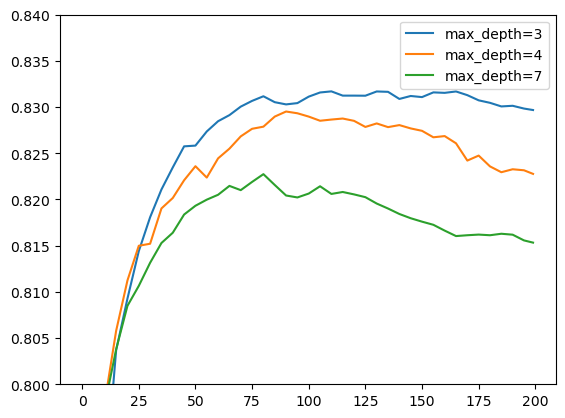

In [78]:
# For each learning parameter and its corresponding scores
for max_depth, df_score in scores.items():
    # Plot score vs iteration number
    plt.plot(df_score.num_iter, df_score.val_auc, label = max_depth)

# Limit y - axis
plt.ylim(0.8, 0.84)
# Legend
plt.legend()
# Visualize
plt.show()

In [79]:
# Initialize score
scores = {}

In [80]:
%%capture output

# Model's parameters
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Model training
model = xgb.train(xgb_params, dtrain,
                  num_boost_round = 200,
                  verbose_eval = 5,
                  evals = watchlist)

In [81]:
# Let's make `min_child_weight` parameter value a scores key
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])

# Check the key
print(key)

min_child_weight=30


In [82]:
# Value score for corresponsing `min_child_weight` parameter
scores[key] = parse_xgb_output(output)

# Visualize result for a particular `min_child_weight`
scores[key].sort_values(by = "val_auc", ascending = False).head()

,num_iter,train_auc,val_auc
31,155,0.89918,0.83743
32,160,0.89970,0.83743
28,140,0.89760,0.83731
30,150,0.89866,0.83728
29,145,0.89821,0.83718


In [83]:
%%capture output

# Model's parameters
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 10,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Model training
model = xgb.train(xgb_params, dtrain,
                  num_boost_round = 200,
                  verbose_eval = 5,
                  evals = watchlist)

In [84]:
# Let's make `min_child_weight` parameter value a scores key
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])

# Check the key
print(key)

min_child_weight=10


In [85]:
# Value score for corresponsing `min_child_weight` parameter
scores[key] = parse_xgb_output(output)

# Visualize result for a particular `min_child_weight`
scores[key].sort_values(by = "val_auc", ascending = False).head()

,num_iter,train_auc,val_auc
33,165,0.91895,0.83535
32,160,0.91795,0.83515
31,155,0.91700,0.83506
26,130,0.91208,0.83490
28,140,0.91435,0.83486


In [86]:
%%capture output

# Model's parameters
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,  
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Model training
model = xgb.train(xgb_params, dtrain,
                  num_boost_round = 200,
                  verbose_eval = 5,
                  evals = watchlist)

In [87]:
# Let's make `min_child_weight` parameter value a scores key
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])

# Check the key
print(key)

min_child_weight=1


In [88]:
# Value score for corresponsing `min_child_weight` parameter
scores[key] = parse_xgb_output(output)

# Visualize result for a particular `min_child_weight`
scores[key].sort_values(by = "val_auc", ascending = False).head()

,num_iter,train_auc,val_auc
22,110,0.92297,0.83170
26,130,0.92789,0.83169
33,165,0.93553,0.83169
27,135,0.92926,0.83165
31,155,0.93274,0.83159


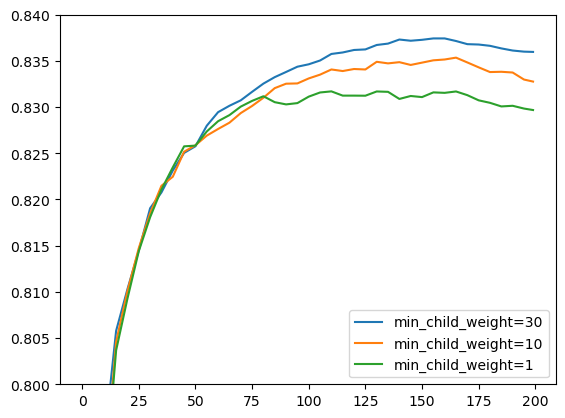

In [89]:
# For each learning parameter and its corresponding scores
for min_child_weight, df_score in scores.items():
    # Plot score vs iteration number
    plt.plot(df_score.num_iter, df_score.val_auc, label = min_child_weight)

# Limit y - axis
plt.ylim(0.8, 0.84)
# Legend
plt.legend()
# Visualize
plt.show()

In [90]:
# Optimal parameters
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Model training
model = xgb.train(xgb_params, dtrain, num_boost_round = 175)

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Useful ones:

* `subsample` (indicates how to sample rows for model training) and `colsample_bytree` (controls how many features trees can get for training)
* `lambda` and `alpha` for weights regularization. Increasing these values make the model more conservative.

## 6.9 Selecting the final model

* Choosing between xgboost, random forest and decision tree
* Training the final model
* Saving the model

In [91]:
# Initialize an optimal decision tree
dt = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 15)
# Model training
dt.fit(X_train, y_train)

# Make soft predictions
y_pred = dt.predict_proba(X_val)[:, 1]
# AUC score
roc_auc_score(y_val, y_pred)

0.785470804775859

In [92]:
# Initialize an optimal random forest
rf = RandomForestClassifier(n_estimators = 200,
                            max_depth = 10,
                            min_samples_leaf = 3,
                            random_state = 1)
# Model training
rf.fit(X_train, y_train)

# Make soft predictions
y_pred = rf.predict_proba(X_val)[:, 1]
# AUC score
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [93]:
# Optimal parameters
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Model training
model = xgb.train(xgb_params, dtrain, num_boost_round = 175)

# Make soft predictions
y_pred = model.predict(dval)
# AUC score
roc_auc_score(y_val, y_pred)

0.836632074786273

Thus, the best model is `xgboost` as it got the best score on validation data.

In [94]:
# Full train data set
df_full_train = df_full_train.reset_index(drop = True)

# Extract target from full train data set
y_full_train = (df_full_train.status == 'default').astype(int).values

In [95]:
# Delete target to keep only features in dataframe
del df_full_train['status']

In [96]:
# Convert to list of dictionaries
dicts_full_train = df_full_train.to_dict(orient = 'records')
# Initialize vectorizer
dv = DictVectorizer(sparse = False)
# One-Hot-Encoding
X_full_train = dv.fit_transform(dicts_full_train)

# Convert to list of dictionaries
dicts_test = df_test.to_dict(orient = 'records')
# One-Hot-Encoding
X_test = dv.transform(dicts_test)

# Format training data structure
dfulltrain = xgb.DMatrix(X_full_train, label = y_full_train,
                    feature_names = list(dv.get_feature_names_out()))
# Format test data structure
dtest = xgb.DMatrix(X_test, feature_names = list(dv.get_feature_names_out()))

In [97]:
# Optimal model parameters
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Model training
model = xgb.train(xgb_params, dfulltrain, num_boost_round = 175)

# Make predictions
y_pred = model.predict(dtest)

# Final AUC score
roc_auc_score(y_test, y_pred)

0.8311543912809736

## 6.10 Summary

* Decision trees learn if-then-else rules from data.
* Finding the best split: select the least impure split. This algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
* Random forest is a way of combininig multiple decision trees. It should have a diverse set of models to make good predictions.
* Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting. 



## 6.11 Explore more

* For this dataset we didn't do EDA or feature engineering. You can do it to get more insights into the problem.
* For random forest, there are more parameters that we can tune. Check `max_features` and `bootstrap`.
* There's a variation of random forest caled "extremely randomized trees", or "extra trees". Instead of selecting the best split among all possible thresholds, it selects a few thresholds randomly and picks the best one among them. Because of that extra trees never overfit. In Scikit-Learn, they are implemented in `ExtraTreesClassifier`. Try it for this project.
* XGBoost can deal with NAs - we don't have to do `fillna` for it. Check if not filling NA's help improve performance.
* Experiment with other XGBoost parameters: `subsample` and `colsample_bytree`.
* When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than otheres. See example here for [random forest](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) (it's the same for plain decision trees) and for [xgboost](https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost)
* Trees can also be used for solving the regression problems: check `DecisionTreeRegressor`, `RandomForestRegressor` and the `objective=reg:squarederror` parameter for XGBoost.


---